# Advanced Econometrics III
## Assignment 1
The volatility index (VIX) is a measure of the volatility of the S&P 500 index, constructed from option prices; see https://www.cboe.com/micro/vix/vixwhite.pdf. The file VIX.csv contains daily data on the VIX over the years 1991–2017. We are going to work with the natural logarithm of the VIX given by $Xt = \ln(\text{VIX}_{t})$. Before we start answering the questions, we first import the data into the notebook.

In [1]:
# Download the data from Github. Note that the file is first deleted if it
# already exists in the directory.
!rm -f VIX.csv
!wget https://raw.githubusercontent.com/Mathijs995/Advanced-Econometrics-III/master/VIX.csv

# List the files in the current folder to show the download was successful.
!ls

--2019-03-31 15:18:05--  https://raw.githubusercontent.com/Mathijs995/Advanced-Econometrics-III/master/VIX.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116104 (113K) [text/plain]
Saving to: ‘VIX.csv’

VIX.csv             100%[===================>] 113.38K  --.-KB/s    in 0.02s   

2019-03-31 15:18:05 (5.11 MB/s) - ‘VIX.csv’ saved [116104/116104]

sample_data  VIX.csv


Before we import the VIX data into this notebook, we first import the packages used in the notebook.

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We continue by importing and transforming the data. This is what the data looks like:

In [3]:
# Import the VIX data.
df = pd.read_csv("VIX.csv")
df.Date = pd.to_datetime(df.Date, format='%Y%m%d')
df.head()

,Date,VIX
0,1990-12-31,26.379999
1,1991-01-02,26.620001
2,1991-01-03,27.930000
3,1991-01-04,27.190001
4,1991-01-07,28.950001


### Question 1
Make a time series plot of $X_{t}$ and of its first difference $\Delta X_{t}$. Next, make a plot of the sample autocorrelation functions $\gamma^{n}(h)$ of $X_{t}$ and of $\Delta X_{t}$, for $h = 1, \ldots , 50$. Judging from these plots, would you choose to model $X_{t}$ as a stationary and invertible ARMA process, or would you start building such a model for $\Delta X_{t}$?

#### Answer to question 1
The code below first derive the first difference $\Delta X_{t}$. Afterwards, the autocorrelation functions $\gamma^{n}(h)$ of $X_{t}$ and of $\Delta X_{t}$, for $h = 1, \ldots , 50$ are plotted.

Text(0, 0.5, '$\\Delta X_t$')

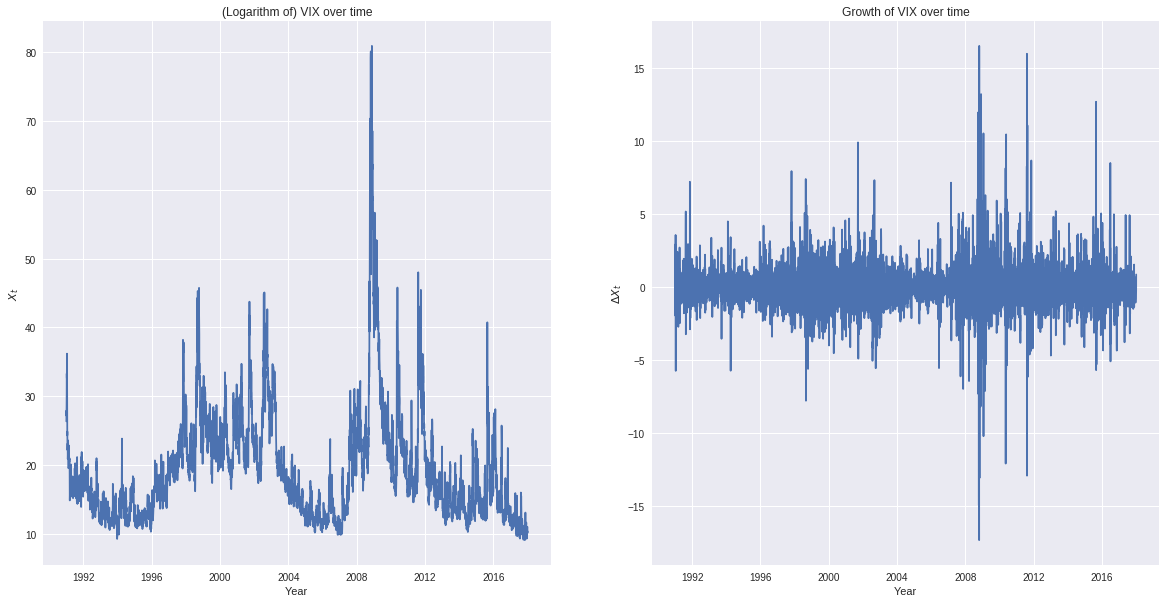

In [4]:
# Create time plot of X_t and delta X_t.
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

fig = axes[0].plot(df.Date, df.VIX)
fig = axes[1].plot(df.Date, df.VIX.diff())
axes[0].set_title('(Logarithm of) VIX over time')
axes[1].set_title('Growth of VIX over time')
for i in range(2):
  axes[i].set_xlabel('Year')
axes[0].set_ylabel(r'$X_t$')
axes[1].set_ylabel(r'$\Delta X_t$')

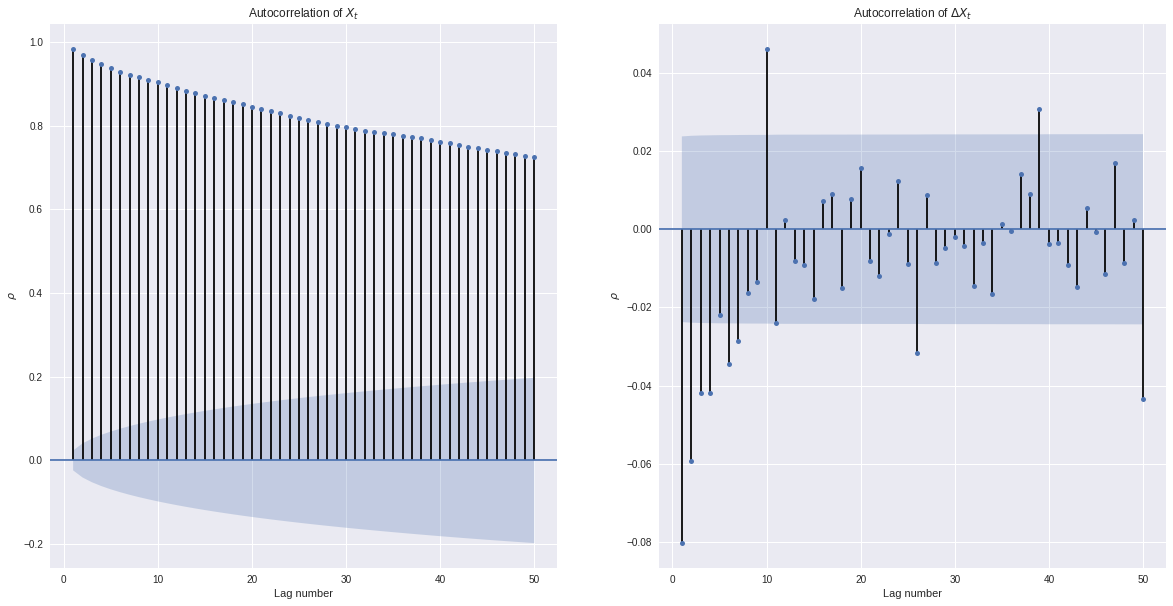

In [5]:
# Define the X_t variable.
X = np.log(df["VIX"].values)
X = X.reshape((X.shape[0],1))

# Define the first difference variable.
fd_X = np.diff(X.reshape(X.shape[0],))

# Define lag constants.
MIN_LAG = 1
MAX_LAG = 50

# Plot the autocorrelation functions.
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig = plot_acf(X, lags=range(MIN_LAG, MAX_LAG + 1), ax=axes[0])
fig = plot_acf(fd_X, lags=range(MIN_LAG, MAX_LAG + 1), ax=axes[1])
axes[0].set_title(r'Autocorrelation of $X_t$')
axes[1].set_title(r'Autocorrelation of $\Delta X_t$')
for i in range(2):
  axes[i].set_xlabel('Lag number')
  axes[i].set_ylabel(r'$\rho$')

Judging from the plots, $X_{t}$ does not seem to be a stationary and invertible ARMA process while $\Delta X_{t}$ seems to be stationary and invertible (or  at least more so). Hence, we would start building a model for $\Delta X_{t}$.

### Question 2
A formal answer to the question whether differencing is needed for stationarity can be obtained from a unit root (Dickey-Fuller) test. This is a test for $H_{0} : X_{t} \sim I(1)$ against the alternative $H_{1} : X_{t} \sim I(0)$. The simplest version rejects the null hypothesis when $t_{\delta} < -2.86$, where $t_{\delta}$ is the $t$-ratio of $\delta$ in the OLS regression
$$\Delta X_{t} = \mu + \delta X_{t-1} + \gamma_{1}\Delta X_{t-1} + \ldots + \gamma_{p-1} \Delta X_{t-p+1} + \varepsilon_{t}.$$
The number of lags p can be chosen by minimising the Schwarz criterion / BIC.

\[Note that -2.86 differs from the usual 5% critical value for $t$-ratios, because the asymptotic distribution theory for these tests is non-standard.\]

Carry out the test, and report on what you find. Is the result in agreement with your answer to question 1?

#### Answer to question 2
Before we find the optimal number of lags $p$ according to the Scharz criterion / BIC, we introduce a new function that returns the regressor matrix and the regressand vector given a number of lags $p$.

In [0]:
def regressors_given_p(fd_X, X, p):
    """
    Purpose:
      Constructs the regressor matrix mX and the regressand vector vY
      for a given number of lags p.

    Inputs:
      fd_X    np.array, first differenced dependent variable
      X       np.array, dependent variable
      p       int, number of lags

    Return value:
      vY      np.array, regressand vector of the model
      mX      np.array, regressor matrix of the model
    """
    # Reshape the first differenced regressand vector to be able to use it.
    fd_X = fd_X.reshape(fd_X.shape[0], 1)
    ones = np.ones((len(X)-p-1))
    ones = ones.reshape((ones.shape[0],1))
    vY = fd_X[p:]
    mX = np.concatenate((ones, X[p:-1], np.concatenate([fd_X[p - i - 1: - i - 1] for i in range(p)], axis=1)), axis=1)
    return vY, mX

Now that we have a function that returns the regressor matrix and the regressand vector for a given number of lags, we can find the optimal number of lags $p$ according to the Scharz criterion / BIC.

In [7]:
# Define the minimum and maximum number of lags.
MIN_P = 1
MAX_P = 20
BIC_scores = []

def get_BIC(vY, mX, vB):
  """
  Purpose:
    Computes the value of the BIC given data and parameters.

  Inputs:
    vY      np.array, regressand vector
    mX      np.array, regressor matrix
    vB      np.array, OLS estimator

  Return value:
    BIC     float, value of the BIC
  """
  N = len(vY)
  K = len(mX.T)
  resid = vY - mX @ vB
  SSE = sum(resid**2)
  BIC = N * np.log(SSE / N) + K * np.log(N)
  return BIC


# Finding the optimal number of lags p.
for p in range(MIN_P, MAX_P + 1):
  vY, mX = regressors_given_p(fd_X, X, p)
  vB = np.linalg.inv(mX.T @ mX) @ mX.T @ vY
  BIC = get_BIC(vY, mX, vB)
  BIC_scores.append(BIC)

# Get the optimal number of lags.
opt_p = np.argmin(BIC_scores) + 1

# Initialize the regressand vector, the regressor matrix and the OLS estimator
# for the optimal number of lags.
vY, mX = regressors_given_p(fd_X, X, opt_p)
vB = np.linalg.inv(mX.T @ mX) @ mX.T @ vY

# Print the optimal number of lags to the console with the corresponding BIC value.
print("The optimal number of lags is {} with a BIC value of {:.5f}.".format(opt_p, float(BIC_scores[opt_p - 1])))

The optimal number of lags is 4 with a BIC value of -37645.98672.


Before we carry out the Dickey-Fuller test, we first initialize a method that can be used to find the $t$-statistic for a given parameter and a given null hypothesis in the model defined above.

In [0]:
def t_statistic(vY, mX, vB, ind_par, h0):
    """
    Purpose:
      Computes the t-statistic for a given parameter with index par_ind and a
      given null hypothesis h0.

    Inputs:
      vY      np.array, regressand vector
      mX      np.array, regressor matrix
      vB      np.array, OLS estimator
      ind_par int, index of parameter to compute the t-statistic for
      h0      float, value of the parameter under the null hypothesis

    Return value:
      t       float, t-statistic
    """
    N = len(vY)
    K = len(mX.T)
    resid = vY - mX @ vB
    SSE = sum(resid**2)
    
    # Estimate covariance matrix
    mCov_hat = np.linalg.inv(mX.T @ mX) * SSE / (N - K)
    
    # Compute the t-statistic.
    t = (vB[par_ind] - h0) / np.sqrt(np.diag(mCov_hat)[par_ind])
    
    return t


We continue by carrying out the Dickey-Fuller test.

In [9]:
# Define the parameter inputs for the Dickey-Fuller test.
par_ind = 1 # We are interested in the second parameter delta.
h0 = 0 # We test the null hypothesis X is integrated of order one which implies
       # that delta should be equal to 0.
  
# Apply the Dickey-Fuller test.
t = t_statistic(vY, mX, vB, par_ind, h0)
print('The point estimate for delta is {:.5f}.'.format(float(vB[par_ind])))
print('The t-statistic for testing whether the process is integrated of ',
          'order one is {:.5f}.'.format(float(t)))

The point estimate for delta is -0.01271.
The t-statistic for testing whether the process is integrated of  order one is -5.81685.


Even though $\hat{\delta}$ is close to 0, we get a high $t$-statistic (in absolute terms) because the estimate is very precise ($n=6800$). In conclusion, the null hypothesis is rejected and we conclude that the process is **not** integrated of order one.

### Question 3
Calculate and plot an estimate of the spectral density of $\Delta X_{t}$, using the Bartlett kernel. You may experiment with the lag length $\ell$ in the range of $\ell \in \{10, \ldots , 50\}$, and pick the one that you consider sufficiently smooth but still informative enough about the shape of the spectrum.

\[This is admittedly subjective; asymptotic theory just tells us that we should have $\ell \to \infty$ and $\ell/n \to 0$, which does not help much in practice; one could use cross-validation techniques, but this is not required for this assignment.\]

#### Answer to question 3
First we define a function that estimates the spectral density using the Bartlett kernel.

In [0]:
def bartlett_kernel(params):
  """
    Purpose:
      Returns the Bartlett kernal value for a given h and given l.
      
    Inputs:
      params       tuple, (h,l) where
      h            int, number of steps away
      l            int, lag length
      
    Return value:
      w            float, weight
    """
  h = params[0]
  l = params[1]
  if abs(h) > l:
    return 0
  return 1 - abs(h) / (1 + l)


def spec_dens_est(X, l, lambda_par, weight_func = lambda x: 1):
    """
    Purpose:
      Estimates the spectral density using the Bartlett kernel for a given
      lambda.
      
    Inputs:
      X            np.array, time series data
      l            int, number of lags
      lambda_par   float, lambda parameter
      bartlett     1 or 0, determines whether bartlett window is used
    Return value:
      f            float, function value
    """
    N = len(X)
    avg = np.mean(X)
    
    # Estimate autocovariances
    gammas = sm.tsa.stattools.acovf(X, unbiased=True)
    
    # Here is code to do it manually but for some reason it's very slow
#     gammas = []
#     fd_X_demean = fd_X - avg
#     for h in range(N):
#       gammas.append(1/(N-h)*np.sum([fd_X_demean[i+h]*fd_X_demean[i] for i in range(N-h)]))
    
    # Estimate spectral density
    sum_val = 0
    for h in range(-N + 1, N):
       sum_val += weight_func((h,l)) * np.cos(lambda_par * h) * gammas[abs(h)]
      
    return 1 / (2 * np.pi) * sum_val

Next, we plot of the resulting estimates of the spectral density for $\ell \in \{10, 11, 12 \ldots, 50\}$:

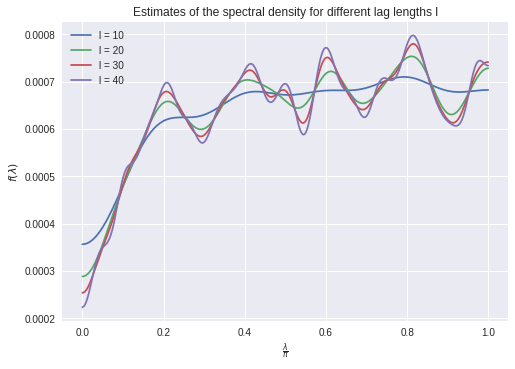

In [11]:
# Construct the vector of intervals.
lambda_vals = np.arange(0, np.pi, 0.01)

# Define number of lags and increment
MIN_L = 10
MAX_L = 50
INC = 10

for l in range(MIN_L,MAX_L,INC):
  lab = 'l = ' + str(l)
  plt.plot(lambda_vals / np.pi, spec_dens_est(fd_X, l, lambda_vals, weight_func = bartlett_kernel), label = lab)
  
# Customize the figure.
plt.title("Estimates of the spectral density for different lag lengths l")
plt.xlabel(r'$\frac{\lambda}{\pi}$')
plt.ylabel(r'$f(\lambda)$')
plt.legend()

The figure shows that a lag number of 10 is sufficiently detailed yet smooth enough. Hence, we set $\ell = 10$ for the following questions.

In [0]:
l = 10

### Question 4
Given the answers to questions 1 and 2, one might expect that $X_{t}$ is not well characterised as either $I(0)$ or $I(1)$, but that it may be considered fractionally integrated of order $d_{X} \in (0,1)$. Previous research suggests that we may expect $d_{X}$ to lie between 0.5 and 1, which would mean that $\Delta X_{t}$ is stationary and $I(d)$ with $d = d_{X} - 1$, so that $-0.5 < d < 0$. Therefore, apply the Geweke-Porter-Hudak estimator (with $m = \lfloor \sqrt{n}\rfloor)$ to the $\Delta X_{t}$ series. Is the estimate significantly different from 0?

#### Answer to question 4
We start by writing a function for the Geweke-Porter-Hudak estimator.

In [0]:
def GPH_est(X, l, m = int(np.sqrt(len(X)))):
    """
    Purpose:
      Geweke-Porter-Hudak estimator of d for a given time series.
      
    Inputs:
      X      np.array, time series
      l      int, number of lags
      m      int, m parameter of the method
      
    Return value:
      d_est  float, estimated value
      t_test float, t-statistic belonging to the test for H0: d = 0.
    """
    N = len(X)
    
    # Note that we leave out the first few lambda_j's up to j=m as the slides suggest
    lambda_js = np.array([2 * np.pi * j / N for j in range(l + 1, m+1)])
    
    vY = np.log(spec_dens_est(X, l, lambda_js))
    mX = np.vstack((np.ones(m-l), np.log(abs(2 * np.sin(0.5 * lambda_js))))).T
    vB = np.linalg.inv(mX.T @ mX) @ mX.T @ vY
    
    d_est = vB[1] * -0.5
    t_stat = t_statistic(vY, mX, vB, 1 , h0 = 0)
    
    return d_est, t_stat

It remains to apply the estimator and test whether the resulting estimate significantly differs from 0.

In [14]:
# Apply the Geweke-Porter-Hudak estimator.
d_est, t_stat = GPH_est(fd_X, l)

# Define the critical value of the t-test using the asymptotic distribution.
z_crit = 1.96

# Print the results.
print("The estimate of d is {:.5f} and the t-statistic is {:.5f}.".format(d_est, t_stat), end = " ")
if abs(t_stat) > z_crit:
  print("The coefficient estimate for d is significantly different from zero.")
else:
  print("The coefficient estimate for d is not significantly different from zero.")

The estimate of d is -0.17212 and the t-statistic is 4.54466. The coefficient estimate for d is significantly different from zero.


### Question 5
Fit an $\text{ARFIMA}(1, d, 1)$ model to $\Delta X_{t}$, estimating $d$ jointly with the other parameters.

\[ARFIMA packages are available in R, Matlab and Ox; EViews also allows for estimation of $d$.\]

Report the estimates and their standard errors. Also, calculate and plot the acf and spectral density corresponding to the estimated model, and compare it with the non-parametric estimates from questions 1 and 3.

#### Answer to question 5
The ARFIMA model is fitted using the $\texttt{fracdiff::fracdiff}$ method in $\texttt{R}$. The code used and the result are shown below:

$\texttt{# Import and pre-process the data.}$

$\texttt{dataset <- readr::read_csv("fd_X.csv")}$

$\texttt{fd_X <- dataset\$`0`}$

$\texttt{# Estimate the ARFIMA model.}$

$\texttt{arfima_model <- fracdiff::fracdiff(fd_X, nar = 1, nma = 1, drange=c(-0.5, 0))}$

$\texttt{ar <- c(arfima_model\$ar)}$

$\texttt{ma <- -c(arfima_model\$ma) # Note that the MA coefficients have inverted signs compared to other parametrizations.}$

$\texttt{sigma <- arfima_model\$sigma}$

$\texttt{d <- arfima_model\$d}$

$\texttt{# Print model parameters to console.}$

$\texttt{print(paste0("AR coefficient: ", ar))}$

$\texttt{print(paste0("MA coefficient: ", ma))}$

$\texttt{print(paste0("Fractional-differencing parameter: ", d))}$

$\texttt{print(paste0("Sigma: ", sigma))}$

$\texttt{# Simulate 10000 observations to plot the theoretical autocorrelation function.}$

$\texttt{num_sim <- 10000}$

$\texttt{lag.max <- 50}$

$\texttt{sim_fd_X <- fracdiff::fracdiff.sim(n=num_sim, ar=ar, ma=-ma, d=d, rand.gen=function(n) (rnorm(n, mean=0, sd=sigma)))}$

$\texttt{filtered_fd_X <- fracdiff::diffseries(fd_X, d)}$

$\texttt{# Plot the simulated autocorrelation function for 50 lags.}$

$\texttt{z <- acf(sim_fd_X\$series, lag.max=lag.max)}$

$\texttt{plot(z\$acf[2:lag.max],}$

$\texttt{    type='h',}$
     
$\texttt{    main='Autocorrelation of first differenced X\_t',}$

$\texttt{    xlab="Lag number",}$

$\texttt{    ylab='acf',}$

$\texttt{    ylim=c(-0.1, 0.1),}$

$\texttt{    las=1,}$

$\texttt{    xaxt="n")}$

$\texttt{abline(h=0)}$
$\texttt{axis(1, at=c(1:lag.max), labels=c(1:lag.max))}$

---

$\text{AR coefficient: } 0.3380683694499$

$\text{MA coefficient: } -0.203013389754166$

$\text{Fractional-differencing parameter: } -0.239431748166926$

$\text{Sigma: } 0.0623353427479977$

In [15]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/Mathijs995/Advanced-Econometrics-III/master/AE3%20-%20Assignment%201%20-%20ARFIMA%20acf%20plot.png")

The resulting estimate for d is close to the GPH estimate. We generated 10000 observations from this model and plotted the resulting autocorellation function. The result is very similar to the actual autocorrelation function (from the data) that we found in question 1.



Next, we find the spectral density function and plot it. Say $Y_t$ follows an ARMA(1,1) process with parameters $\phi$ and $\theta$. Then it's spectral density is $f_Y(\lambda)=\frac{\sigma^2}{2 \pi} \frac{|(1+\theta e^{-i\lambda})|^2}{|(1-\phi e^{-i\lambda})|^2}=\frac{\sigma^2}{2 \pi} \frac{1+2 \theta \cos(\lambda)+\theta^2}{1-2 \phi \cos(\lambda)+\phi^2} $. Similarly, if $Z_t$ follows an ARFIMA(0,d,0) process, it's spectral density is given by $f_Z(\lambda)= \frac{\sigma^2}{2 \pi} (2(1-\cos(\lambda)))^{-d} $. We can combine these two results to find the spectral density of the ARFIMA(1,d,1) process we are interested in:  $f_Z(\lambda)= \frac{2 \pi}{\sigma^2} f_Y(\lambda) f_Z(\lambda)$. This function is plotted below for the estimated parameter values:

$\phi=0.338, d=-0.2394, \theta=-0.203, \sigma=0.0623$.

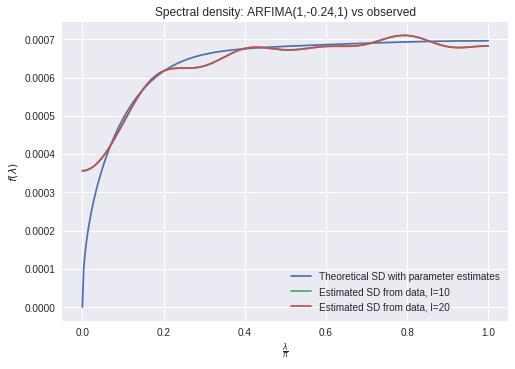

In [16]:
def spec_dens(lambda_par, phi, d, theta, sigma_sq=1):
    """
    Purpose:
      Spectral density function for an ARFIMA(1,d,1) process
    Inputs:
      lambda_par   float, frequency
      phi          float, coefficient of AR(1)
      d            float, order of integration
      phi          float, coefficient of MA(1)
      sigma_sq     float, white noise variance
      
    Return value:
      f  float, value of spectral density
    """
    # Specify the elements of spectral density corresponding to ARMA and d
    dens_arma = (1+2*theta*np.cos(lambda_par)+theta**2)/(1-2*phi*np.cos(lambda_par)+phi**2)
    dens_d = (2*(1-np.cos(lambda_par)))**(-d)
    return sigma_sq/(2*np.pi)*dens_arma*dens_d
  
lambda_vals = np.arange(0, np.pi, 0.01)
plt.plot(lambda_vals / np.pi, spec_dens(lambda_vals, 0.338, -0.2394, -0.203,
                                        sigma_sq=0.0623**2),
         label='Theoretical SD with parameter estimates')
plt.plot(lambda_vals / np.pi, spec_dens_est(fd_X, 10, lambda_vals,
                                            weight_func = bartlett_kernel),
         label='Estimated SD from data, l=10')
plt.plot(lambda_vals / np.pi, spec_dens_est(fd_X, l, lambda_vals,
                                            weight_func = bartlett_kernel),
         label='Estimated SD from data, l=20')
plt.title("Spectral density: ARFIMA(1,-0.24,1) vs observed")
plt.xlabel(r'$\frac{\lambda}{\pi}$')
plt.ylabel(r'$f(\lambda)$')
plt.legend()

As we can see, the spectral density of an ARFIMA(1, -0.24, 1) with parameters equal to our estimates is very similar to the spectral desnity we estimated from the data earlier (especially with l=10).

### Question 6
Use diagnostic tests to judge if the model of question 5 can be further improved.

#### Answer to question 6
For the purpose of analysing the model from 5) further, we manually filter the series with the fractional differencing filter $\Delta^d=\sum_j^\infty \binom{d}{j} (-L)^j $ with d equal to our estimate, -0.2394. In theory, we need infinitely many lags for this filter; however, in practice the weights approach 0 relatively quickly and we found that the last filtered observation when including only 200 lags is very close to the result for the last observation when including all (i.e. 6802) previous lags. Of course, since we need 200 lags, we are left with 200 observations less.

In [0]:
def frac_diff_filter(X, d, lags=200):
    """
    Purpose:
      Uses the fractional differencing filter (d) on time series X.
      
    Inputs:
      X            array, data
      d            float, order of integration
      lags         int, number of lags used and burn-in
      
    Return value:
      fil_X        array, filtered data
    """
    N = len(X)
    
    # Calculate the weights
    vW = []
    for j in range(0,lags):
      w = (-1)**(j)*scipy.special.binom(d, j)
      vW.append(w)
    fil_X = []
    
    # Filter
    for i in range(lags+1,N+1):
      x = X[i-lags:i]
      x = x[::-1]
      fil_X.append(x.T@vW)
    return fil_X

fil_X = frac_diff_filter(fd_X, -0.2394317)

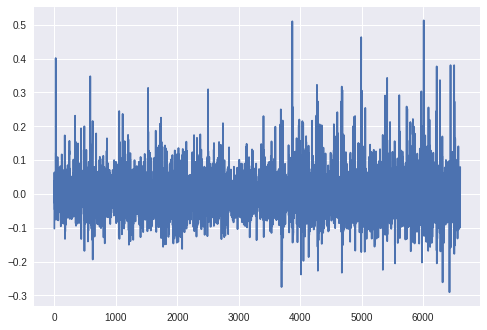

In [20]:
plt.plot(fil_X)
plt.show()

We now fit an ARMA(1,1) model to the filtered series, which should (and does) give us the same estimates for $\phi$ and $\theta$.

In [21]:
model = ARIMA(fil_X, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 6603
Model:                     ARMA(1, 1)   Log Likelihood                8942.263
Method:                       css-mle   S.D. of innovations              0.062
Date:                Sun, 31 Mar 2019   AIC                         -17876.526
Time:                        15:20:43   BIC                         -17849.345
Sample:                             0   HQIC                        -17867.133
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.303      0.762      -0.002       0.002
ar.L1.y        0.3374      0.079      4.297      0.000       0.184       0.491
ma.L1.y       -0.2031      0.082     -2.488      0.0

We get the same results as from the ARFIMA package - save for a small difference because of the burn-in phase. In the next step, we will perform residual diagnostics to see whether the model needs further improvement.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


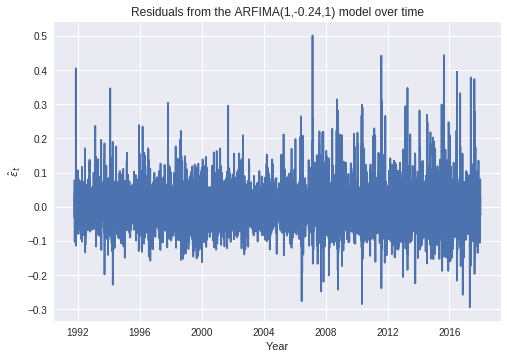

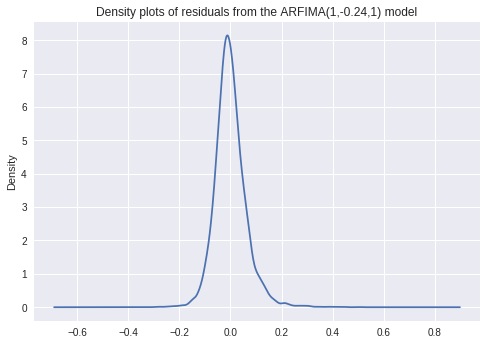

Summary statistics of residuals:
                 0
count  6603.000000
mean      0.000002
std       0.062466
min      -0.293683
25%      -0.036745
50%      -0.005488
75%       0.030693
max       0.501641


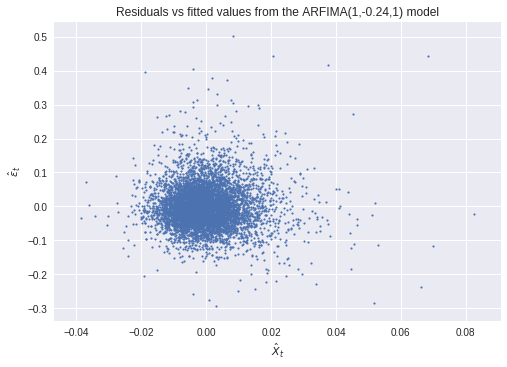

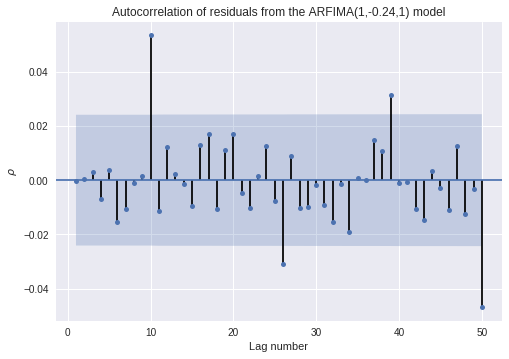

In [22]:
residuals = pd.DataFrame(model_fit.resid)
fittedvals = pd.DataFrame(model_fit.fittedvalues)

# Plot residuals
plt.plot(df.Date[201:], residuals)
plt.ylabel(r'$\hat{\epsilon}_t$')
plt.xlabel('Year')
plt.title('Residuals from the ARFIMA(1,-0.24,1) model over time')
plt.show()

# Plot density of residuals
residuals.plot(kind='kde', legend=False)
plt.title('Density plots of residuals from the ARFIMA(1,-0.24,1) model')
plt.show()

# Summary statistics of residuals
print('Summary statistics of residuals:')
print(residuals.describe())

# Plot residuals
plt.scatter(fittedvals,residuals, s=3)
plt.xlabel(r'$\hat{X}_t$')
plt.ylabel(r'$\hat{\epsilon}_t$')
plt.title('Residuals vs fitted values from the ARFIMA(1,-0.24,1) model')
plt.show()

# Plot acf of residuals
plot_acf(residuals, lags=range(MIN_LAG, MAX_LAG + 1))
plt.title('Autocorrelation of residuals from the ARFIMA(1,-0.24,1) model')
plt.xlabel('Lag number')
plt.ylabel(r'$\rho$')
plt.show()

The p-value of the Jarque-Bera test for normality in residuals is 0.00000.
The Durbin-Watson test statistic for residual autocorrelation is 1.99962.
The p-value of the Breusch Godfrey Lagrange Multiplier tests for residual autocorrelation is 0.13829.
The p-value of the Breusch-Pagen test for heteroskedasticity is 0.00000.


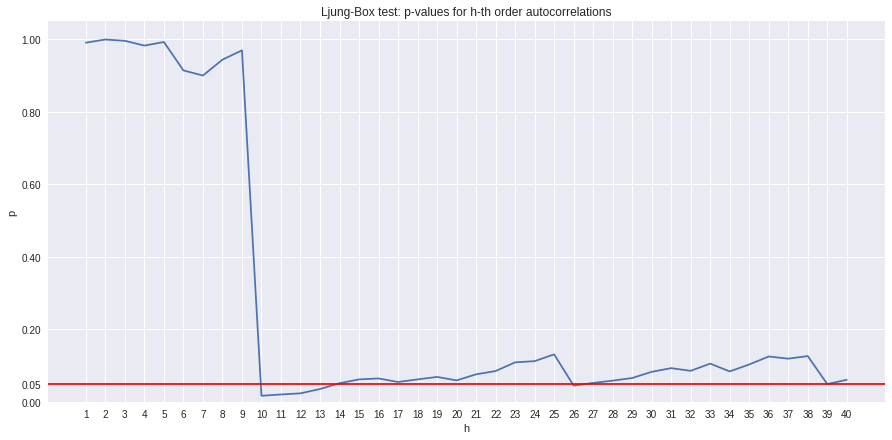

In [55]:
# Jarque-Bera test for normality in residuals
print('The p-value of the Jarque-Bera test for normality in residuals is {:.5f}.'
      .format(float(sm.stats.stattools.jarque_bera(residuals)[1])))

# Durbin-Watson test for for residual autocorrelation
print('The Durbin-Watson test statistic for residual autocorrelation is {:.5f}.'
      .format(float(sm.stats.stattools.durbin_watson(residuals))))

# Breusch Godfrey Lagrange Multiplier tests for residual autocorrelation
print('The p-value of the Breusch Godfrey Lagrange Multiplier tests for residual autocorrelation is {:.5f}.'
      .format(float(sm.stats.diagnostic.acorr_breusch_godfrey(model_fit)[1])))

# Breusch-Pagan test for heteroskedasticity
print('The p-value of the Breusch-Pagen test for heteroskedasticity is {:.5f}.'
      .format(sm.stats.diagnostic.het_breuschpagan(resid=residuals[1:],
                                                   exog_het=np.hstack((np.array(fil_X[:-1]), residuals[:-1])))[1]))

# Ljung-Box Q-test whether any of the autocorrelations of order 1 to 40 are significant
plt.figure(figsize=(15,7))
plt.plot(np.arange(1,41,1),sm.stats.diagnostic.acorr_ljungbox(residuals)[1])
plt.yticks(list(plt.yticks()[0]) + [0.05])
plt.xticks(np.arange(1,41,1))
plt.ylim(0, 1.05)
plt.title('Ljung-Box test: p-values for h-th order autocorrelations')
plt.ylabel('p')
plt.xlabel('h')
plt.axhline(y=0.05, color='Red')
plt.show()

The residuals appear to be normally distributed and have mean 0  but Jarque-Bera test rejects indicating that errors are in fact not normally distributed. Furthermore, errors are heteroskedastic as clearly visible from a scatterplot of residuals and fitted values. This is confirmed by the Breusch-Pagan test in which we cannot reject the dependence of the residual variance on the explanatory variables (in a specific form). The Breusch-Godfrey test indicates that there is no serial correlation left in the erros, even though the ACF plot indicates that some higher autocorellations (10, 39, 50) are significant. The Ljung-Box test also indicates that some of the higher order (10 to 13, as well as 26 and 39) autocorrelations are significant.

These results indicate that the model gets rid of almost all serial correlation in the residuals, which is our foremost goal. There is, however, still evidence that the model could be further improved, such as the non-normal, heteroskedastic residuals and some of their higher order autocorrelations being significant in the Ljung-Box test.